In [1]:
%pip install torch torchvision torchaudio
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install Pillow
%pip install matplotlib

import torch
import PIL
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import clip

model, preprocess = clip.load('ViT-B/16')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model.to(device)

100%|████████████████████████████████████████| 335M/335M [00:03<00:00, 111MiB/s]


Using device: cuda


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [20]:
#image_path = 'cars_parking_lot.jpg'
image_path = 'parking_lot_cars2.jpg'
#image_path = 'fruitontable.jpg'
image = None
try:
    image = PIL.Image.open(image_path)
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")

In [66]:
text_inputs = ["car", "not a car"]

In [95]:
text_tokens = clip.tokenize(text_inputs).to(device)

original_image = PIL.Image.open(image_path)

confidence_threshold = 0.90
detections = []
window_sizes = [64, 128, 192]

for size in window_sizes:
    for y in range(0, original_image.height - size, 32):
        for x in range(0, original_image.width - size, 32):
            box = (x, y, x + size, y + size)
            patch = original_image.crop(box)

            preprocessed_patch = preprocess(patch).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(preprocessed_patch)
                text_features = model.encode_text(text_tokens)

                image_features /= image_features.norm(dim=-1, keepdim=True)
                text_features /= text_features.norm(dim=-1, keepdim=True)
                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

                confidence = similarity[0][0].item()

            if confidence > confidence_threshold:
                detections.append((box, confidence))

print(f"{len(detections)} potential detections.")

43 potential detections.


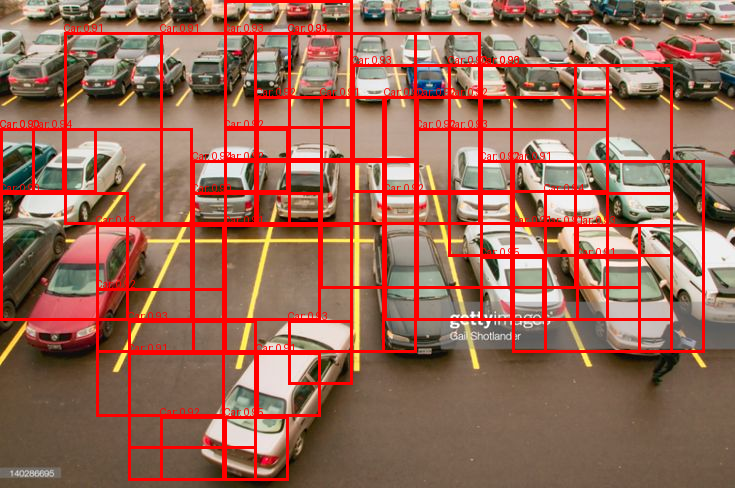

In [96]:
from PIL import ImageDraw

draw = ImageDraw.Draw(original_image)
for box, confidence in detections:
    draw.rectangle(box, outline="red", width=3)
    text = f"Car: {confidence:.2f}"
    draw.text((box[0], box[1] - 10), text, fill="red")

display(original_image)

In [97]:
import torchvision

boxes_tensor = torch.tensor([list(d[0]) for d in detections], dtype=torch.float32)
scores_tensor = torch.tensor([d[1] for d in detections], dtype=torch.float32)

iou_threshold = 0.1
indices = torchvision.ops.nms(boxes_tensor, scores_tensor, iou_threshold)
final_detections = [detections[i] for i in indices]

print(f"{len(final_detections)} detections after NMS.")

12 detections after NMS.


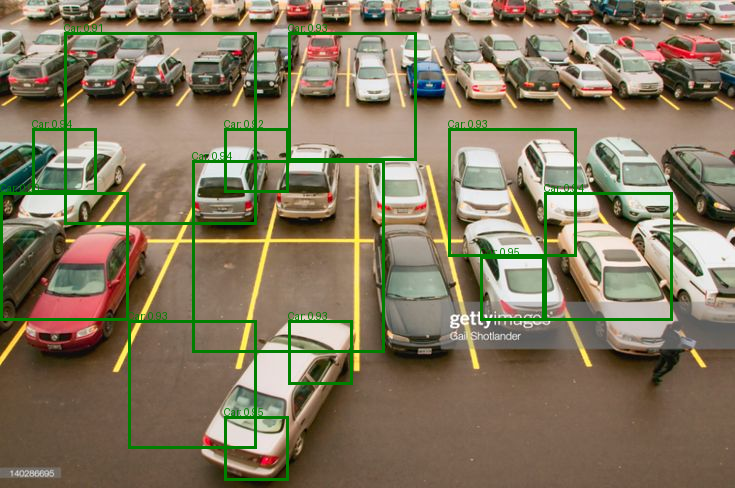

In [99]:
from PIL import ImageDraw

image_after_nms = PIL.Image.open(image_path)
draw = ImageDraw.Draw(image_after_nms)
for box, confidence in final_detections:
    draw.rectangle(box, outline="green", width=3)
    text = f"Car: {confidence:.2f}"
    draw.text((box[0], box[1] - 10), text, fill="green")

display(image_after_nms)
